# ASSIGNMENT DATA SCIENCE
## Problem statement
Our road networks are equipped with various sensors that measure traffic. ANPR (Automatic Number Plate Recognition) cameras monitor the road and use character recognition algorithms to detect and read license plates of vehicles. Inductive counting loops on the other hand are placed under the road surface and can detect vehicles passing over them.

In this particular case, the ANPR camera **CPT-C-0002.1** and the inductive counting loop **01A** are located on the same road segment close to each other. This means that we expect these two sensors to produce identical information about the traffic they observe.

The goal of this exercise is to make an analysis in order to demonstrate that (1) the two sensors work fine, or (2) one sensor is working properly and the other not, or (3) both sensors produce erroneous results. The analysis should be focused on the vehicle counts provided by the two sensors, but speed information is also provided and can be used. 

Make use of Python, its libraries and this Jupyter notebook to help you out and visualise your findings. The Jupyter notebook will be used to discuss your analysis, used logic and conclusions with members of the data science team. Every additional bit of useful information about the data is welcome and can be discussed.

We wish you the best of luck! If you have any questions, please use the following email address: bruno.cornelis@macq.eu


## Structure of the data
### Counting loop (*pboc_data_rv.csv*)

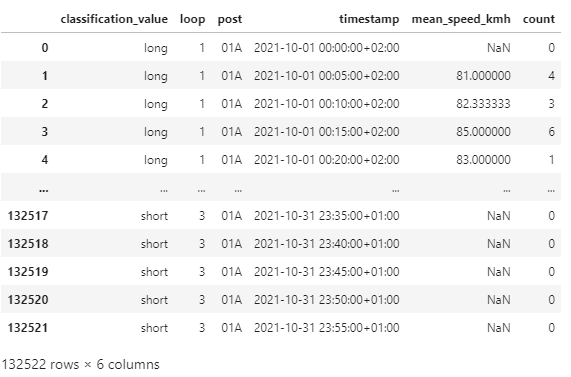

In [3]:
from PIL import Image
Image.open('./images/img_data_pboc_rv.png')

**Features**:
- **classification_value**: classification of the detected vehicle. "short", "medium", "long" represent the length of the vehicle.
- **loop**: id of the loop placed on a single lane of the road. There is one loop on each lane of the road.
- **post**: unique id of the counting post containing the different loops.
- **timestamp**: time of the observation. *Important:* The data is aggregated every 5 minutes.
- **mean_speed_kmh**: average speed of the vehicles detected in km/h.
- **count**: count of the vehicles.

**Explanation for the second row of the Data Frame**:  
There are 4 long vehicles detected by loop 1 of post 01A between 00:05 and 00:10. The average speed of those 4 vehicles equals 81 km/h.  

### ANPR camera (*pfic_data_rv.csv*)

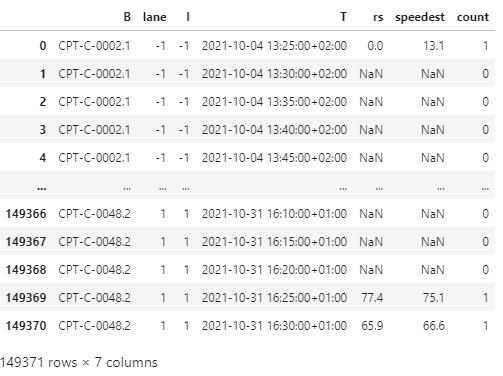

In [6]:
Image.open('./images/img_data_pfic_rv.png')

**Features**:
- **B**: unique ID of a camera
- **lane**: id of the lane observed by the camera (-1:unknown, 1:lane1, 2:lane2). *Be careful:* this camera does not observe traffic on the fastest lane. We don't know if 1 or 2 is the lane in the middle. 
- **l**: classification of the vehicle made by the camera (-1:unknown, 0:short vehicle, 1:long vehicle).
- **T**: time of the observation. The data is aggregated every 5 minutes.
- **rs**: average speed returned by the radar fixed to the camera in km/h.
- **speedest**: speed estimation from the camera in km/h.
- **count**: count of the vehicles.

**Explanation of the last row of the Data Frame**:  
There is 1 long vehicle detected by camera CPT-C-0048.2 on lane 1 between 16:30 and 16:35. The average speed is 65.9 km/h from the radar and 66.6 from the camera 